# Survival Analysis in Python

Chapter 1

Allen B. Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

import utils
from utils import decorate
from empyrical_dist import Pmf, Cdf

Data from [https://gist.github.com/epogrebnyak/7933e16c0ad215742c4c104be4fbdeb1]

```
Dataset from:
    
V.J. Menon and D.C. Agrawal,  Renewal Rate of Filament Lamps: 
Theory and Experiment. Journal of Failure Analysis and Prevention. 
December 2007, p. 421, Table 2/
DOI: 10.1007/s11668-007-9074-9

Description:

An assembly of 50 new Philips (India) lamps with the 
rating 40 W, 220 V (AC) was taken and installed in the horizontal 
orientation and uniformly distributed over a lab area 11 m 9 7 m. 

The assembly was monitored at regular intervals of 12 h to
look for failures. The instants of recorded failures were
called t‘ and a total of 32 data points were obtained such
that even the last bulb failed. 

Variables:

i - observation number
h - time in hours since experiment start
f - number of failed lamps at particular time h
K - number of surviving lamps  at particular time h
```

In [2]:
df = pd.read_csv("data/lamps.csv")
df.head()

,i,h,f,K
0,0,0,0,50
1,1,840,2,48
2,2,852,1,47
3,3,936,1,46
4,4,960,1,45


In [3]:
pmf = Pmf(df.f.values, index=df.h)
pmf.normalize()
pmf.head()

h
0      0.00
840    0.04
852    0.02
936    0.02
960    0.02
dtype: float64

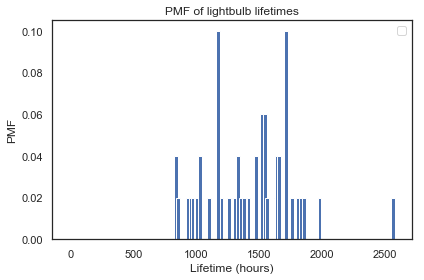

In [4]:
pmf.bar(width=30)
decorate(xlabel='Lifetime (hours)', 
         ylabel='PMF', 
         title='PMF of lightbulb lifetimes')

In [5]:
cdf = pmf.make_cdf()
cdf.head()

h
0      0.00
840    0.04
852    0.06
936    0.08
960    0.10
dtype: float64

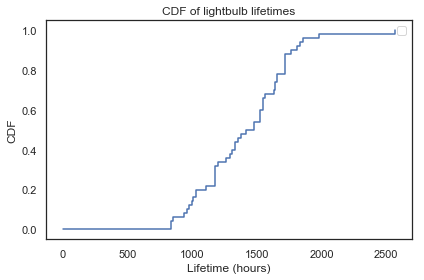

In [6]:
cdf.step()
decorate(xlabel='Lifetime (hours)', 
         ylabel='CDF', 
         title='CDF of lightbulb lifetimes')

In [7]:
def make_surv(cdf):
    return Surv(1-cdf.ps, index=cdf.qs)

Cdf.make_surv = make_surv

In [8]:
def underride(d, **options):
    """Add key-value pairs to d only if key is not in d.

    d: dictionary
    options: keyword args to add to d

    :return: modified d
    """
    for key, val in options.items():
        d.setdefault(key, val)

    return d

In [9]:
from scipy.interpolate import interp1d

class Surv(pd.Series):
    """Represents a survival function (complementary CDF)."""

    def __init__(self, *args, **kwargs):
        """Initialize a survival function.

        Note: this cleans up a weird Series behavior, which is
        that Series() and Series([]) yield different results.
        See: https://github.com/pandas-dev/pandas/issues/16737
        """
        if args:
            super().__init__(*args, **kwargs)
        else:
            underride(kwargs, dtype=np.float64)
            super().__init__([], **kwargs)

    def copy(self, deep=True):
        """Make a copy.

        :return: new Surv
        """
        return Surv(self, copy=deep)

    @staticmethod
    def from_seq(seq, normalize=True, sort=True, **options):
        """Make a Surv from a sequence of values.

        seq: any kind of sequence
        normalize: whether to normalize the Surv, default True
        sort: whether to sort the Surv by values, default True
        options: passed to the pd.Series constructor

        :return: Surv object
        """
        pmf = Pmf.from_seq(seq, normalize=False, sort=sort, **options)
        cdf = pmf.make_cdf(normalize=normalize)
        return cdf.make_surv()

    @property
    def qs(self):
        """Get the quantities.

        :return: NumPy array
        """
        return self.index.values

    @property
    def ps(self):
        """Get the probabilities.

        :return: NumPy array
        """
        return self.values

    def _repr_html_(self):
        """Returns an HTML representation of the series.

        Mostly used for Jupyter notebooks.
        """
        df = pd.DataFrame(dict(probs=self))
        return df._repr_html_()

    def plot(self, **options):
        """Plot the Cdf as a line.

        :param options: passed to plt.plot
        :return:
        """
        underride(options, label=self.name)
        plt.plot(self.qs, self.ps, **options)

    def step(self, **options):
        """Plot the Cdf as a step function.

        :param options: passed to plt.step
        :return:
        """
        underride(options, label=self.name, where='post')
        plt.step(self.qs, self.ps, **options)

    def normalize(self):
        """Make the probabilities add up to 1 (modifies self).

        :return: normalizing constant
        """
        total = self.ps[-1]
        self /= total
        return total

    @property
    def forward(self, **kwargs):
        """Compute the forward Cdf

        :param kwargs: keyword arguments passed to interp1d

        :return array of probabilities
        """

        underride(kwargs, kind='previous',
                  copy=False,
                  assume_sorted=True,
                  bounds_error=False,
                  fill_value=(1, 0))

        interp = interp1d(self.qs, self.ps, **kwargs)
        return interp

    @property
    def inverse(self, **kwargs):
        """Compute the inverse Cdf

        :param kwargs: keyword arguments passed to interp1d

        :return array of quantities
        """
        interp = self.make_cdf().inverse
        return lambda ps: interp(1-ps, **kwargs) 
        
    # calling a Cdf like a function does forward lookup
    __call__ = forward

    # quantile is the same as an inverse lookup
    quantile = inverse
    
    def make_cdf(self, normalize=False):
        """Make a Cdf from the Surv.

        :return: Cdf
        """
        cdf = Cdf(1-self.ps, index=self.qs)
        if normalize:
            cdf.normalize()
        return cdf

    def make_pmf(self, normalize=False):
        """Make a Pmf from the Surv.

        :return: Pmf
        """
        cdf = self.make_cdf(normalize=False)
        pmf = cdf.make_pmf(normalize=normalize)
        return pmf
    
    def make_hazard(self, **kwargs):
        """Make a Hazard object from the Surv.

        :return: Hazard object
        """
        # TODO: Get the Pandas-idiomatic version of this
        lams = pd.Series(index=self.qs)

        prev = 1.0
        for q, p in self.iteritems():
            lams[q] = (prev - p) / prev
            prev = p

        return Hazard(lams, **kwargs)

    def choice(self, *args, **kwargs):
        """Makes a random sample.

        Uses the probabilities as weights unless `p` is provided.

        args: same as np.random.choice
        options: same as np.random.choice

        :return: NumPy array
        """
        # TODO: Make this more efficient by implementing the inverse CDF method.
        pmf = self.make_pmf()
        return pmf.choice(*args, **kwargs)

    def sample(self, *args, **kwargs):
        """Makes a random sample.

        Uses the probabilities as weights unless `weights` is provided.

        This function returns an array containing a sample of the quantities in this Pmf,
        which is different from Series.sample, which returns a Series with a sample of
        the rows in the original Series.

        args: same as Series.sample
        options: same as Series.sample

        :return: NumPy array
        """
        # TODO: Make this more efficient by implementing the inverse CDF method.
        pmf = self.make_pmf()
        return pmf.sample(*args, **kwargs)

    def mean(self):
        """Expected value.

        :return: float
        """
        return self.make_pmf().mean()

    def var(self):
        """Variance.

        :return: float
        """
        return self.make_pmf().var()

    def std(self):
        """Standard deviation.

        :return: float
        """
        return self.make_pmf().std()

    def median(self):
        """Median (50th percentile).

        :return: float
        """
        return self.quantile(0.5)

In [10]:
surv = cdf.make_surv()
surv.head()

0      1.00
840    0.96
852    0.94
936    0.92
960    0.90
dtype: float64

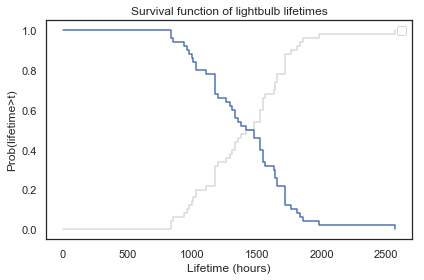

In [11]:
cdf.step(color='gray', alpha=0.3)
surv.step()
decorate(xlabel='Lifetime (hours)', 
         ylabel='Prob(lifetime>t)', 
         title='Survival function of lightbulb lifetimes')

In [12]:
surv(-1)

array(1.)

In [13]:
surv(3000)

array(0.)

In [14]:
surv.median()

array(1416.)

In [15]:
surv.mean()

1413.8399999999997

In [16]:
class Hazard(pd.Series):
    """Represents a Hazard function."""

    def __init__(self, *args, **kwargs):
        """Initialize a Hazard.

        Note: this cleans up a weird Series behavior, which is
        that Series() and Series([]) yield different results.
        See: https://github.com/pandas-dev/pandas/issues/16737
        """
        if args:
            super().__init__(*args, **kwargs)
        else:
            underride(kwargs, dtype=np.float64)
            super().__init__([], **kwargs)

    def copy(self, deep=True):
        """Make a copy.

        :return: new Pmf
        """
        return Hazard(self, copy=deep)

    def __getitem__(self, qs):
        """Look up qs and return ps."""
        try:
            return super().__getitem__(qs)
        except (KeyError, ValueError, IndexError):
            return 0

    @property
    def qs(self):
        """Get the quantities.

        :return: NumPy array
        """
        return self.index.values

    @property
    def ps(self):
        """Get the probabilities.

        :return: NumPy array
        """
        return self.values

    def _repr_html_(self):
        """Returns an HTML representation of the series.

        Mostly used for Jupyter notebooks.
        """
        df = pd.DataFrame(dict(probs=self))
        return df._repr_html_()

    def mean(self):
        """Computes expected value.

        :return: float
        """
        raise ValueError()
        
    def median(self):
        """Median (50th percentile).

        :return: float
        """
        raise ValueError()

    def quantile(self, ps, **kwargs):
        """Quantiles.

        Computes the inverse CDF of ps, that is,
        the values that correspond to the given probabilities.

        :return: float
        """
        raise ValueError()

    def var(self):
        """Variance of a PMF.

        :return: float
        """
        raise ValueError()


    def std(self):
        """Standard deviation of a PMF.

        :return: float
        """
        raise ValueError()

    def choice(self, *args, **kwargs):
        """Makes a random sample.

        Uses the probabilities as weights unless `p` is provided.

        args: same as np.random.choice
        kwargs: same as np.random.choice

        :return: NumPy array
        """
        raise ValueError()

    def sample(self, *args, **kwargs):
        """Makes a random sample.

        Uses the probabilities as weights unless `weights` is provided.

        This function returns an array containing a sample of the quantities,
        which is different from Series.sample, which returns a Series with a sample of
        the rows in the original Series.

        args: same as Series.sample
        options: same as Series.sample

        :return: NumPy array
        """
        raise ValueError()


    def plot(self, **options):
        """Plot the Pmf as a line.

        :param options: passed to plt.plot
        :return:
        """
        underride(options, label=self.name)
        plt.plot(self.qs, self.ps, **options)

    def bar(self, **options):
        """Makes a bar plot.

        options: passed to plt.bar
        """
        underride(options, label=self.name)
        plt.bar(self.qs, self.ps, **options)

    
    def make_cdf(self, normalize=True):
        """Make a Cdf from the Hazard.

        It can be good to normalize the cdf even if the Pmf was normalized,
        to guarantee that the last element of `ps` is 1.

        :return: Cdf
        """
        cdf = self.make_surv().make_cdf()
        return cdf
    
    def make_surv(self, normalize=True):
        """Make a Surv from the Hazard.

        :return: Surv
        """
        ps = (1 - self.ps).cumprod()
        return Surv(ps, index=self.qs)
        
    @staticmethod
    def from_seq(seq, **options):
        """Make a PMF from a sequence of values.

        seq: any kind of sequence
        normalize: whether to normalize the Pmf, default True
        sort: whether to sort the Pmf by values, default True
        options: passed to the pd.Series constructor

        :return: Pmf object
        """
        cdf = Cdf.from_seq(seq, **options)
        surv = cdf.make_surv()
        return surv.make_hazard()

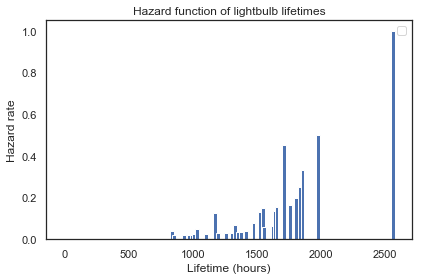

In [17]:
haz = surv.make_hazard()
haz.bar(width=30)
decorate(xlabel='Lifetime (hours)', 
         ylabel='Hazard rate', 
         title='Hazard function of lightbulb lifetimes')

In [18]:
surv2 = haz.make_surv()

In [19]:
max(abs(surv - surv2))

3.469446951953614e-18

In [20]:
cdf2 = surv2.make_cdf()
max(abs(cdf - cdf2))

5.551115123125783e-17

In [21]:
pmf2 = cdf2.make_pmf()
max(abs(pmf.ps - pmf2.ps))

9.367506770274758e-17

In [22]:
from scipy.stats import gaussian_kde

def estimate_smooth_hazard(pmf):
    xs = np.linspace(min(pmf.qs), max(pmf.qs))
    
    kde = gaussian_kde(pmf.qs, weights=pmf.ps)
    pdf = Pmf(kde(xs), index=xs)
    pdf.normalize()
    
    ps = pdf.make_cdf().make_surv().forward(xs)
    surv = Surv(ps, index=xs)
    
    lams = pdf.ps / surv
    haz = Hazard(lams)
    
    return pdf, surv, haz

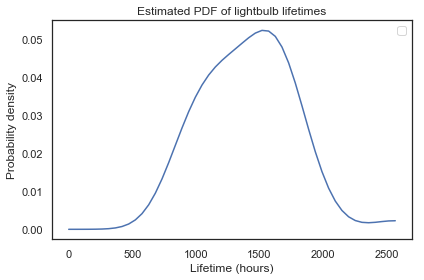

In [23]:
pdf, surv, haz = estimate_smooth_hazard(pmf)
pdf.plot()
decorate(xlabel='Lifetime (hours)', 
         ylabel='Probability density', 
         title='Estimated PDF of lightbulb lifetimes')

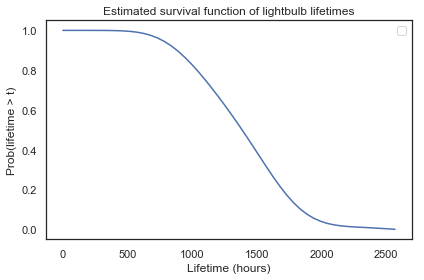

In [24]:
surv.plot()
decorate(xlabel='Lifetime (hours)', 
         ylabel='Prob(lifetime > t)', 
         title='Estimated survival function of lightbulb lifetimes')

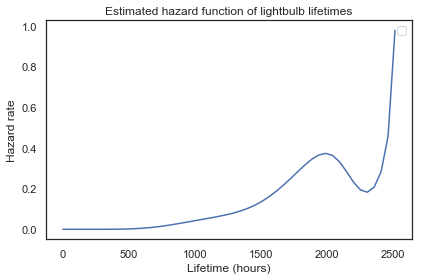

In [25]:
haz.plot()
decorate(xlabel='Lifetime (hours)', 
         ylabel='Hazard rate', 
         title='Estimated hazard function of lightbulb lifetimes')

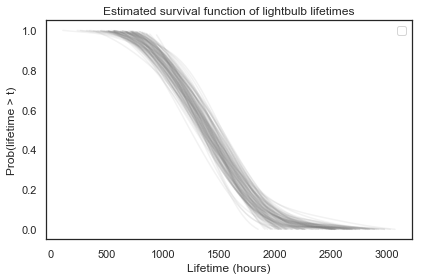

In [26]:
pmf = Pmf(df.f.values, index=df.h)
kde = gaussian_kde(pmf.qs, weights=pmf.ps)

size = pmf.sum()

for i in range(100):
    sample = kde.resample(size).flatten()
    pdf, surv, haz = estimate_smooth_hazard(Pmf.from_seq(sample))
    surv.plot(color='gray', alpha=0.1)
    
decorate(xlabel='Lifetime (hours)', 
         ylabel='Prob(lifetime > t)', 
         title='Estimated survival function of lightbulb lifetimes')

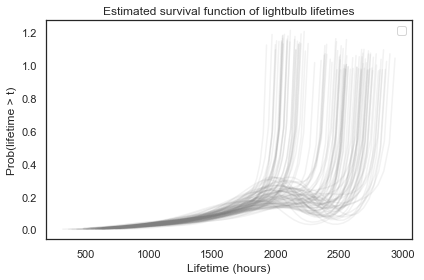

In [27]:
for i in range(100):
    sample = kde.resample(size).flatten()
    pdf, surv, haz = estimate_smooth_hazard(Pmf.from_seq(sample))
    haz.plot(color='gray', alpha=0.1)
    
decorate(xlabel='Lifetime (hours)', 
         ylabel='Prob(lifetime > t)', 
         title='Estimated survival function of lightbulb lifetimes')

In [28]:
from collections import Counter

pmf = Pmf(df.f.values, index=df.h)
counter = Counter(dict(pmf.iteritems()))
data = np.fromiter(counter.elements(), dtype=np.int64)
len(data), pmf.sum()

(50, 50)

In [29]:
from scipy.stats import exponweib

a, c, loc, scale = exponweib.fit(data)

/home/downey/anaconda3/envs/SurvivalAnalysisPython/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:1469: RuntimeWarning: invalid value encountered in add
  negxc + sc.xlogy(c - 1.0, x))


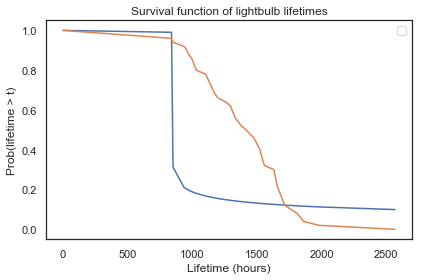

In [30]:
qs = pmf.qs
ps = exponweib(a, c, loc, scale).sf(qs)
plt.plot(qs, ps)

pmf.make_cdf().make_surv().plot()

decorate(xlabel='Lifetime (hours)', 
         ylabel='Prob(lifetime > t)', 
         title='Survival function of lightbulb lifetimes')

### Popcorn

Description of the experiment here:
https://www.reddit.com/r/dataisbeautiful/comments/8uo1q9/popcorn_analytics_oc/
    
Data downloaded from here
https://textuploader.com/dzqpd

In [31]:
df = pd.read_csv('data/popcorn.csv', sep=';')
df.head()

,#,time of the pop in seconds
0,1,120.167
1,2,140.300
2,3,140.367
3,4,142.700
4,5,142.800


In [32]:
data = df['time of the pop in seconds']
pmf = Pmf.from_seq(data)

In [33]:
pdf, surv, haz = estimate_smooth_hazard(pmf)

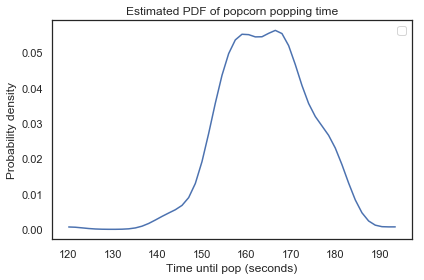

In [34]:
pdf.plot()
decorate(xlabel='Time until pop (seconds)', 
         ylabel='Probability density', 
         title='Estimated PDF of popcorn popping time')

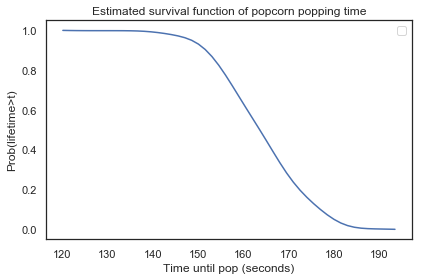

In [35]:
surv.plot()
decorate(xlabel='Time until pop (seconds)', 
         ylabel='Prob(lifetime>t)', 
         title='Estimated survival function of popcorn popping time')

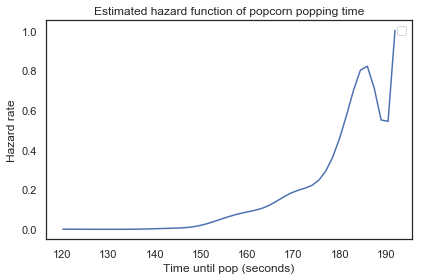

In [36]:
haz.plot()
decorate(xlabel='Time until pop (seconds)', 
         ylabel='Hazard rate', 
         title='Estimated hazard function of popcorn popping time')

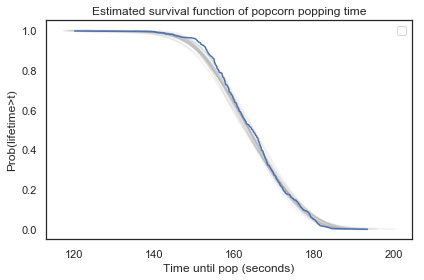

In [37]:
kde = gaussian_kde(data)
size = len(data)

for i in range(20):
    sample = kde.resample(size).flatten()
    pdf, surv, haz = estimate_smooth_hazard(Pmf.from_seq(sample))
    surv.plot(color='gray', alpha=0.1)
    
pmf.make_cdf().make_surv().plot()

decorate(xlabel='Time until pop (seconds)', 
         ylabel='Prob(lifetime>t)', 
         title='Estimated survival function of popcorn popping time')

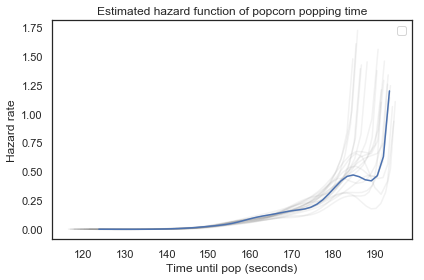

In [38]:
for i in range(20):
    sample = kde.resample(size).flatten()
    pdf, surv, haz = estimate_smooth_hazard(Pmf.from_seq(sample))
    haz.plot(color='gray', alpha=0.1)
    
haz.plot()
decorate(xlabel='Time until pop (seconds)', 
         ylabel='Hazard rate', 
         title='Estimated hazard function of popcorn popping time')

In [39]:
from scipy.stats import exponweib

a, c, loc, scale = exponweib.fit(data)
a, c, loc, scale

/home/downey/anaconda3/envs/SurvivalAnalysisPython/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:1469: RuntimeWarning: invalid value encountered in add
  negxc + sc.xlogy(c - 1.0, x))


(1.2660609147328483, 0.2340662728039207, 120.16699999999999, 1.445804345963988)

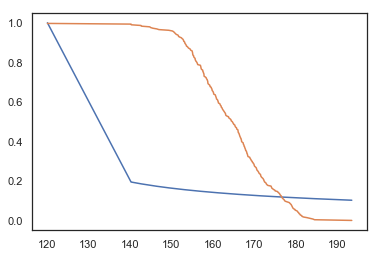

In [40]:
qs = pmf.qs
ps = exponweib(a, c, loc, scale).sf(qs)
plt.plot(qs, ps)
pmf.make_cdf().make_surv().plot()

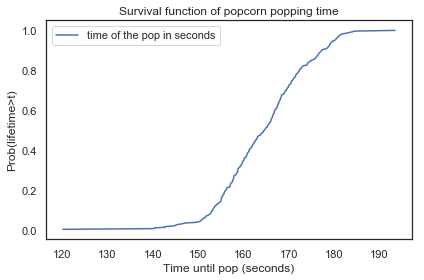

In [41]:
cdf = pmf.make_cdf()
cdf.plot()
decorate(xlabel='Time until pop (seconds)', 
         ylabel='Prob(lifetime>t)', 
         title='Survival function of popcorn popping time')

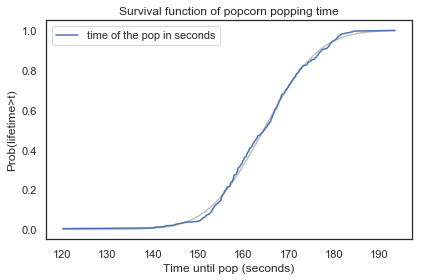

In [42]:
from scipy.stats import norm

rv = norm(pmf.mean(), pmf.std())
qs = np.linspace(data.min(), data.max())
ps = rv.cdf(qs)
model_cdf = Cdf(ps, index=qs)
model_cdf.plot(color='gray', alpha=0.5)

cdf.plot()
decorate(xlabel='Time until pop (seconds)', 
         ylabel='Prob(lifetime>t)', 
         title='Survival function of popcorn popping time')

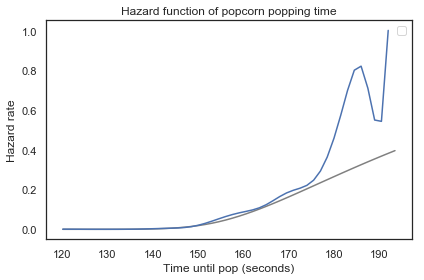

In [48]:
model_haz = model_cdf.make_surv().make_hazard()
model_haz.plot(color='gray')

pdf, surv, haz = estimate_smooth_hazard(pmf)
haz.plot()

decorate(xlabel='Time until pop (seconds)', 
         ylabel='Hazard rate', 
         title='Hazard function of popcorn popping time')

Why estimating the right side of the hazard function is nearly impossible:

1) If we take a data-intensive approach, we are trying to estimate the probabilities of rare events, which is hard.  

2) The right side of the survival curve is noisy enough, but then we amplify the noise twice, first by taking a derivative, and then by dividing through by the survival function as it goes to zero.  In particular, the last point is always bogus.

3) If we take a model-intensive approach, we are depending on the validity of estimating a model based on the bulk of the distribution and then extrapolating into the tail.  But when reality deviates from a model, the tail is where it happens.  In the light-bulb example, the left tail is probably populated by manufacturing defects.  The right tail might include procedural errors (wrong kind of light bulb, operated under non-compliant conditions), measurement errors, recording errors,etc.

If we plot confidence intervals, we are at least aware of where the estimate is not reliable.  But in general it is probably unwise to base any conclusion on the right half of an estimated hazard function.
